In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [3]:
# import reference file
enbasedf = pd.read_excel("./letterlang test/ref/letterorderen_full.xlsx")
thbasedf = pd.read_excel("./letterlang test/ref/letterorderth_full.xlsx")

In [4]:
# clean data, cut and add the data column into base df
def cut_and_clean(basedf, prepdf):
    cutdf = prepdf.iloc[1:97][["lang","langpair","sequence","pairid","key_resp.keys","key_resp.rt"]].reset_index()
    cutdf = cutdf.rename({"key_resp.keys":"key","key_resp.rt":"key_RT"}, axis="columns")
    newdf = basedf
    newdf = newdf.drop(['secondletter', 'seconddir'], axis = 1)
    newdf["key"] = cutdf["key"]
    newdf["key_RT"] = cutdf["key_RT"]
    return newdf


In [5]:
# assign score for speicific condition
def assign_score(df):
    # Create a boolean mask for 'sequence' and 'key' conditions
    mask_seq_1_z = (df['sequence'] == 1) & (df['key'] == 'z')
    mask_seq_2_x = (df['sequence'] == 2) & (df['key'] == 'x')

    # Assign scores based on conditions
    df['score'] = 0  # Default score
    df.loc[mask_seq_1_z, 'score'] = 1
    df.loc[mask_seq_2_x, 'score'] = 1

In [6]:
# assign the letter shown language as a langshow column
def interpret_lang(df):
    # Define conditions based on 'lang' and 'sequence'
    condition_1 = (df['sequence'] == 1) & (df['lang'] == 1)
    condition_2 = (df['sequence'] == 1) & (df['lang'] == 2)
    condition_3 = (df['sequence'] == 2) & (df['lang'] == 1)
    condition_4 = (df['sequence'] == 2) & (df['lang'] == 2)

    # Use numpy.select to vectorize the mapping logic
    langshow = np.select(
        [condition_1 & (df['langpair'] == 1), condition_1 & (df['langpair'] == 2), condition_1 & (df['langpair'] == 3),
         condition_2 & (df['langpair'] == 1), condition_2 & (df['langpair'] == 2), condition_2 & (df['langpair'] == 3),
         condition_3, condition_4],
        ['English', 'Khmer', 'Greek', 
         'Thai', 'Khmer', 'Greek', 
         'Thai', 'English'],
        default='Unknown'
    )

    # Assign the result to the 'langshow' column
    df['langshow'] = langshow




In [7]:
import pandas as pd
import glob
import os

path = './data/letterlang test - data/'
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    user_lang_list = filename.split('_M')[0].split('- data\\')[1].split('_')
    username = user_lang_list[0]
    lang = user_lang_list[1]

    df = pd.read_csv(filename, index_col=None, header=0)
    
    if lang == 'th':
        df = cut_and_clean(thbasedf, df)
    elif lang == 'en':
        df = cut_and_clean(enbasedf, df)
    else:
        print("RENAME YOUR FREAKY ASS FILE NAME")
        break
    
    assign_score(df)
    interpret_lang(df)
    df['username'] = username

    li.append(df)


In [8]:
megadf = pd.concat(li, ignore_index = True)


In [9]:
lien = [li[i] for i in range(0,len(li)) if i % 2 == 0]
lith = [li[i] for i in range(0,len(li)) if i % 2 == 1]

In [10]:
# create a combined df for each norm user
combli = []
n_subj = int(len(li)/2)
for i in range(0,n_subj):
    orderall = pd.concat([li[2*i+1], li[2*i]], ignore_index=True)
    combli.append(orderall)

In [11]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'
patient = '#fc6600'

In [12]:
# for our patient, call the file ./data/patient ...
patientpath = "./data/patient letterlang test/"
all_patientfiles = glob.glob(os.path.join(patientpath , "*.csv"))

li_patient = []
for filename in all_patientfiles:
    user_lang_list = filename.split('_M')[0].split('test\\')[1].split('_')
    print(user_lang_list)
    username = user_lang_list[0]
    lang = user_lang_list[1]

    df = pd.read_csv(filename, index_col=None, header=0)
    
    if lang == 'th':
        df = cut_and_clean(thbasedf, df)
    elif lang == 'en':
        df = cut_and_clean(enbasedf, df)
    else:
        print("RENAME YOUR FREAKY ASS FILE NAME")
        break
    
    assign_score(df)
    interpret_lang(df)
    df['username'] = username

    li_patient.append(df)

# welcome back
letterorden = li_patient[0]
letterordth = li_patient[1]
letterordall = pd.concat([li_patient[0], li_patient[1]], ignore_index=True)


['YP', 'en']
['YP', 'th']


# Plot accuracy of the letter by language task

lang
1    0.467410
2    0.489854
Name: score, dtype: float64


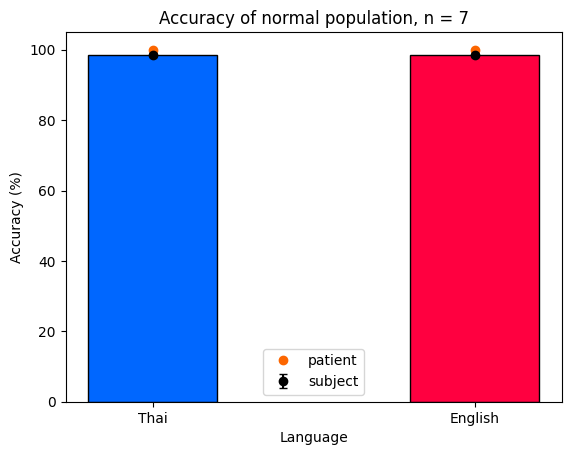

In [13]:
accumean = megadf.groupby('lang')['score'].mean().mul(100)
accusem = megadf.groupby('lang')['score'].sem().mul(100)
print(accusem)
plt.bar(accumean.index, accumean.values, width = 0.4, color = [bluegradient[4], redgradient[4]], edgecolor = 'black')
plt.errorbar(accumean.index, accumean.values, yerr = accusem.values, color = 'black', fmt = 'o', capsize = 3, label = 'subject')
plt.xticks(accumean.index, ['Thai', 'English'])
plt.title(f"Accuracy of normal population, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Accuracy (%)")

plt.plot(accumean.index,[100,100],'o', color =patient, label = 'patient')
plt.legend()
plt.savefig("./figure/norm/I accu by lang.png")

# Plot accuracy by language

langshow
Thai       98.214286
English    99.776786
Khmer      98.214286
Greek      96.428571
Name: score, dtype: float64


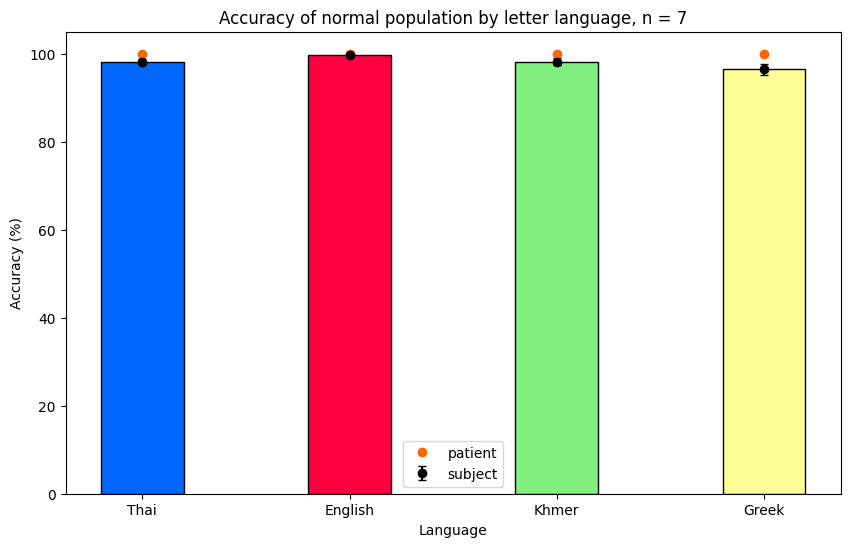

In [14]:
accumean = megadf.groupby('langshow')['score'].mean().mul(100)
accumean = accumean.reindex(['Thai', 'English', 'Khmer','Greek'])

print(accumean)
accusem = megadf.groupby('langshow')['score'].sem().mul(100)
accusem = accusem.reindex(['Thai', 'English', 'Khmer','Greek'])

plt.subplots(figsize=(10, 6))

plt.bar(accumean.index, accumean.values, width = 0.4, color = [bluegradient[4],redgradient[4], '#80ef80', '#fdfd96'], edgecolor = 'black')
plt.errorbar(accumean.index, accumean.values, yerr = accusem.values, color = 'black', fmt = 'o', capsize = 3, label = 'subject')
plt.xticks(accumean.index)
plt.title(f"Accuracy of normal population by letter language, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Accuracy (%)")

plt.plot(accumean.index,[100]*4,'o', color =patient, label = 'patient')
plt.legend()
plt.savefig("./figure/norm/I accu by letterlang.png")

Index(['Thai', 'English', 'Khmer', 'Greek'], dtype='object', name='langshow') <class 'pandas.core.indexes.base.Index'>
langshow
Thai       0.723554
English    0.000000
Khmer      1.532478
Greek      0.892857
Name: 1, dtype: float64
langshow
Thai       1.256990
English    0.297619
Khmer      0.892857
Greek      2.297546
Name: 2, dtype: float64


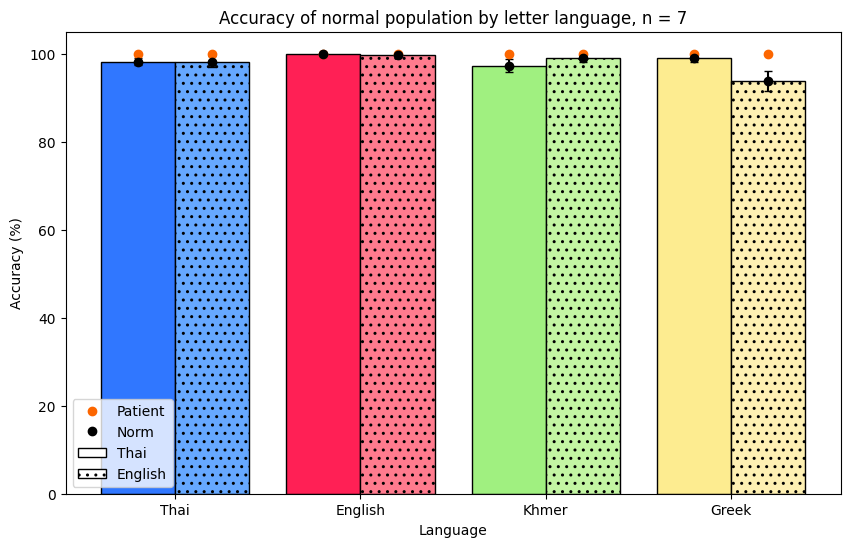

In [15]:
# Aggregate data using pandas
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.4  # bar width
engcol = ["#3077ff", "#ff2055", "#a0f080", "#fdec90"]
thaicol = ["#66a8ff", "#ff7b8e", "#c3f5a3", "#fef0b3"]

accumean = megadf.groupby(['langshow', 'lang'])['score'].mean().mul(100).unstack()
accumean = accumean.reindex(['Thai', 'English', 'Khmer','Greek'], axis=0)

accusem = megadf.groupby(['langshow', 'lang'])['score'].sem().mul(100).unstack()
accusem = accusem.reindex(['Thai', 'English', 'Khmer','Greek'], axis = 0)

print(accumean.index, type(accumean.index))
for i, (lang, sublist) in enumerate(accumean.items()):

    x = np.arange(len(sublist.index)) + (i - 0.5) * width
    y = sublist.values

    langcol = engcol if lang == 1 else thaicol
    pattern = None if lang == 1 else '..'

    print(accusem[i+1])
    plt.bar(x, y, width = width, color = langcol, edgecolor = 'black',label = lang, hatch = pattern)
    plt.errorbar(x, y, yerr = accusem[i+1], color = 'black', fmt = 'o', capsize = 3)

    plt.plot(x, [100]*4, 'o', color = patient)


plt.title(f"Accuracy of normal population by letter language, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Accuracy (%)")
plt.xticks(range(len(accumean)), accumean.index.tolist())
legend_elements = [Patch(facecolor='white', edgecolor='black', label='Thai'),
    Patch(facecolor='white', edgecolor='black', hatch = '..', label='English')]

norm_elements =  [Line2D([0], [0], marker='o', color=patient, linestyle='None', label='Patient', markerfacecolor=patient),
                  Line2D([0, 0], [0, 1], marker='o', color='black', label='Norm', linestyle='None')]

plt.legend(frameon = True, fontsize = 10, handles=norm_elements+ legend_elements)

plt.savefig("./figure/norm/I accu by letterlang by language.png")

# reaction time by letter language
filter data first

In [16]:
# filter only the correct response
megadf_filter = megadf[megadf['score'] == 1].dropna()
letterorden_filter = letterorden[letterorden['score'] == 1].dropna()
letterordth_filter = letterordth[letterordth['score'] == 1].dropna()
letterordall_filter = letterordall[letterordall['score'] == 1].dropna()


## Normality and variance test
to use two sample t-test, the data should be
- normally distributed -->  Shapiro–Wilk test 
- equal variance --> Levene's test

In [17]:
# p < 0.05 --> not normally distributed
from scipy import stats

print("shapiro test in norm:", stats.shapiro(megadf_filter['key_RT']))
print("shapiro test in patient:", stats.shapiro(letterordall_filter['key_RT']))

# p ≤ 0.05 → Reject H₀ → Variances are significantly different
print(stats.levene(letterordall_filter['key_RT'], megadf_filter['key_RT']))


shapiro test in norm: ShapiroResult(statistic=0.3958444595336914, pvalue=0.0)
shapiro test in patient: ShapiroResult(statistic=0.14159756898880005, pvalue=9.770903442588615e-29)
LeveneResult(statistic=7.245926567270427, pvalue=0.007184694835062241)


In [18]:
# not normal dis, use Wilson test
diffall = stats.mannwhitneyu(letterordall_filter['key_RT'], megadf_filter['key_RT'])
diffen = stats.mannwhitneyu(letterorden_filter['key_RT'], megadf_filter.loc[megadf_filter['lang'] == 2, 'key_RT'])
diffth = stats.mannwhitneyu(letterordth_filter['key_RT'], megadf_filter.loc[megadf_filter['lang'] == 1, 'key_RT'])

pt_rtmean = letterordall_filter['key_RT'].mean()
pt_rtsem = letterordall_filter['key_RT'].sem()
norm_rtmean = megadf_filter['key_RT'].mean()
norm_rtsem = megadf_filter['key_RT'].sem()

print(f"patient statistics = {pt_rtmean} ± {pt_rtsem}\nnorm statustics = {norm_rtmean} ± {norm_rtsem}")
print(f"Man whitney U test compare overall: {diffall}")
print(f"Man whitney U test compare thai: {diffth}")
print(f"Man whitney U test compare english: {diffen}")



patient statistics = 0.7210916096041776 ± 0.10663826085118265
norm statustics = 0.3717177172723242 ± 0.01163391555957772
Man whitney U test compare overall: MannwhitneyuResult(statistic=217344.0, pvalue=7.698993132647157e-58)
Man whitney U test compare thai: MannwhitneyuResult(statistic=55138.0, pvalue=2.237569927665492e-31)
Man whitney U test compare english: MannwhitneyuResult(statistic=53646.0, pvalue=1.8273148548499143e-28)


## reaction time in all user vs patient by language

Text(0.5, 0, 'Language')

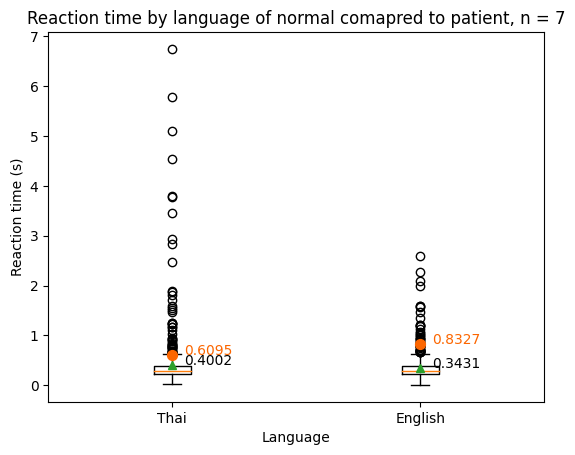

In [62]:
# plot vertical boxplot of norm + errorbar of patient


prep = megadf_filter
# prep = megadf_filter[megadf_filter['username'] != 'PH']
datath = prep.loc[prep['lang'] == 1 , 'key_RT']
datathmean = datath.mean()
dataen = prep.loc[prep['lang'] == 2, 'key_RT']
dataenmean = dataen.mean()

plt.boxplot([datath, dataen],positions=[1,2], vert=True, showmeans=True)
plt.text(1+0.05, datathmean, round(datathmean,4), ha = 'left')
plt.text(2+0.05, dataenmean, round(dataenmean,4), ha = 'left')
plt.xticks([1,2], ['Thai', 'English'])

ptthmean = letterordth_filter['key_RT'].mean()
ptenmean = letterorden_filter['key_RT'].mean()

plt.scatter([1,2], [ptthmean, ptenmean], s = 50, color = patient, marker='o',  zorder=10)
plt.text(1+0.05, ptthmean, round(ptthmean,4), ha = 'left', color = patient)
plt.text(2+0.05, ptenmean, round(ptenmean,4), ha = 'left', color = patient)
plt.title(f"Reaction time by language of normal comapred to patient, n = {n_subj}")
plt.ylabel("Reaction time (s)")
plt.xlabel("Language")


([<matplotlib.axis.XTick at 0x1ee6bcf6500>,
 [Text(1, 0, 'Thai'), Text(2, 0, 'English')])

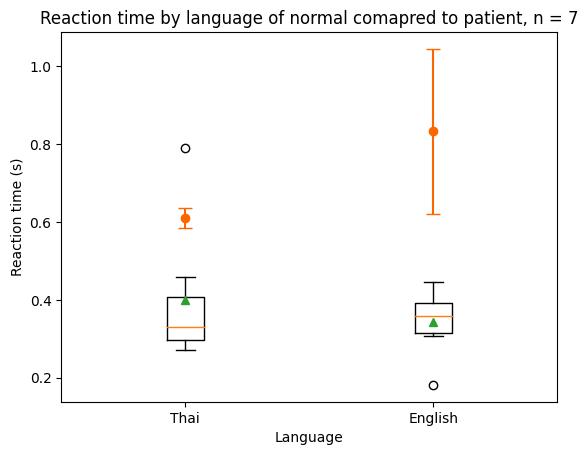

In [65]:
plotdf = megadf_filter.groupby(["username", "lang"])['key_RT'].mean().unstack()
# plotdf = plotdf.drop(index=['PH'])

for i, (lang, series) in enumerate(plotdf.items()):

    plt.boxplot([series.values], positions = [i+1], showmeans=True) 

# patient
ptthmean = letterordth_filter['key_RT'].mean()
ptenmean = letterorden_filter['key_RT'].mean()
ptthsem = letterordth_filter['key_RT'].sem()
ptensem = letterorden_filter['key_RT'].sem()

plt.errorbar([1,2], [ptthmean, ptenmean],yerr = [ptthsem, ptensem], fmt = 'o',color = patient,   zorder=10, capsize = 5)

plt.title(f"Reaction time by language of normal comapred to patient, n = {n_subj}")
plt.ylabel("Reaction time (s)")
plt.xlabel("Language")
plt.xticks([1,2], ['Thai', 'English'])


langshow
Thai       0.409597
English    0.324478
Khmer      0.454367
Greek      0.381847
Name: key_RT, dtype: float64


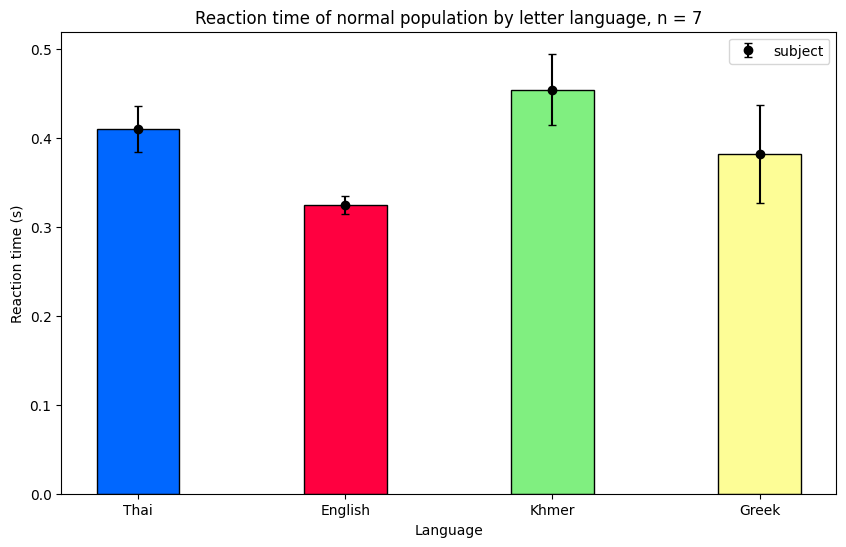

In [ ]:
rtmean = megadf.groupby('langshow')['key_RT'].mean()
rtmean = rtmean.reindex(['Thai', 'English', 'Khmer','Greek'])

print(rtmean)
rtsem = megadf.groupby('langshow')['key_RT'].sem()
rtsem = rtsem.reindex(['Thai', 'English', 'Khmer','Greek'])

plt.subplots(figsize=(10, 6))

plt.bar(rtmean.index, rtmean.values, width = 0.4, color = [bluegradient[4],redgradient[4], '#80ef80', '#fdfd96'], edgecolor = 'black')
plt.errorbar(rtmean.index, rtmean.values, yerr = rtsem.values, color = 'black', fmt = 'o', capsize = 3, label = 'subject')
plt.xticks(rtmean.index)
plt.title(f"Reaction time of normal population by letter language, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Reaction time (s)")

plt.legend()


In [ ]:
from matplotlib.patches import Patch
def I_plot_grouped_reaction_time(data1, data2, lang_order=None,group_names=('Group 1', 'Group 2'), plot_title=None, save_path=None):
    
    # Aggregate data using pandas
    def process_df(df):
        return df.groupby('langshow', observed=True).agg(
            mean_RT=('key_RT', np.nanmean),
            sem_RT=('key_RT', lambda x: np.nanstd(x)/np.sqrt(len(x)))
        ).reindex(lang_order)

    agg1, agg2 = process_df(data1), process_df(data2)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(lang_order))  # label locations
    width = 0.35  # bar width
    
    engcol = ["#3077ff", "#ff2055", "#a0f080", "#fdec90"]

    thaicol = ["#66a8ff", "#ff7b8e", "#c3f5a3", "#fef0b3"]

    # Create grouped bars
    bars1 = ax.bar(x - width/2, agg1['mean_RT'], width, yerr=agg1['sem_RT'], color = thaicol, label=group_names[0], capsize=5, edgecolor = "black")
    bars2 = ax.bar(x + width/2, agg2['mean_RT'], width, yerr=agg2['sem_RT'], color = engcol, label=group_names[1], capsize=5, edgecolor = "black", hatch = '..')
    
    # Add labels and formatting
    ax.set_ylabel('Reaction Time (s)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(lang_order, fontsize=11)
    legend_elements = [Patch(facecolor='white', edgecolor='black', label='Thai'),
        Patch(facecolor='white', edgecolor='black', hatch = '..', label='English')]
    ax.legend(frameon=False, fontsize=10, handles=legend_elements)
    
    
    # Add value labels using list comprehension
    for rect, values in zip([bars1, bars2], [agg1, agg2]):
        for idx, bar in enumerate(rect):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., 
                    height + values['sem_RT'].iloc[idx] + 0.01,
                    f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=9)
    
    plt.ylim(0,1)
    plt.xlabel("Language")
    if plot_title:
        plt.title(plot_title, pad=20, fontsize=14)
    
    if save_path:

        plt.savefig(save_path, bbox_inches='tight', dpi=300, 
                   facecolor='white')
    
    plt.show()

In [ ]:
I_plot_grouped_reaction_time(
    orderth, orderen,
    lang_order=['thai', 'english', 'khmer', 'greek'],
    group_names=('Thai', 'English'),
    plot_title='Reaction Time Comparison between language',
    save_path=f'./figure/{username} I RT by lang grouped.png'
)

NameError: name 'forderth' is not defined